<a href="https://colab.research.google.com/github/bibinjose/WQU_capstone/blob/main/Results%20of%20Case%20Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Value-at-Risk (VaR) and Expected Shortfall (ES) in Commodities



1.  **Convert production + inventory → stochastic revenue/margin**:
We can map the production using the CBOT price, adjusting for the local basis, the FX price, export flows, and storage costs. We use a non-stochastic model since the Commodities follow a non-Gaussian distribution. For that reason, we use Student-t and GARCH volatility or a filter of historical residual. We also have a dependency on time-varying values and the correlation of commodities, FX, and basis.
2.   **Computes VaR, ES, and CFaR on user-defined horizons**:
VAR is used as a standard to measure the tail quantile. ES is the tail mean We take the VAR/ES portfolio and transition to CFaR to plan for liquidity and available cash.
3.   **Sizes regime-aware hedges to meet a CFaR target**:
We establish the structural situation. WE establish the risk and exposure of carrying. We establish the financial conditions and monetary policy. We establish the trend and volatility regime.After deciding on a CFaR target (80% Reduction vs unhedged case) to determine the minimum contracts so that CFaR is less than the target under the established regime.

4.   **Decomposes risk by driver (price, basis, FX, freight)**:
We decompose the revenue CBOT price + basis + FX + freight + carry. We then show in hedge vs Unhedge choosing drivers that establish hedge nature.

5.   **Runs stress & liquidity tests**:
We run different stress test: Historical, Multisigma Shortfall, and other fundamentals, Policy shock, and Liquidity-adjust VaR.

6.   **Reports unhedged vs hedged outcomes**:
We show distributions from P&L, Var/ES/CFaR, stress tables and risk drivers in hedge and unhedge porfolios.






## Establish Portfolio, horizon and model choices

We load prices and do the derivation of returns.

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import t as student_t, jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox
from numpy.linalg import eigh, cholesky

TICKERS = ["ZC=F", "ZS=F", "ZW=F"]
START = "2014-01-01"
END = None
USE_BASIS = False
BASIS_USD_PER_BU = {
    "ZC=F": 0.00,
    "ZS=F": 0.00,
    "ZW=F": 0.00,
}

EXPOSURE_BUSHELS = {"ZC=F": 1_000_000, "ZS=F": 600_000, "ZW=F": 800_000}

HORIZON_DAYS = 20
N_PATHS = 25_000
DIST = "student_t"
T_DF = 6
CONF_VAR = 0.99
CONF_ES = 0.975
CFAR_TARGET_FRACTION = 0.20
FUT_CONTRACT_SIZE = 5_000.0


data = yf.download(TICKERS, start=START, end=END, progress=False)
prices_fut = data["Close"].dropna(how="all")  # $/bu
if isinstance(prices_fut, pd.Series):
    prices_fut = prices_fut.to_frame()

if USE_BASIS:
    basis = pd.DataFrame({t: BASIS_USD_PER_BU.get(t, 0.0) for t in TICKERS}, index=prices_fut.index)
    prices_cash = (prices_fut + basis).dropna(how="any", axis=0)
else:
    prices_cash = prices_fut.copy()

returns = np.log(prices_fut / prices_fut.shift(1)).dropna()


print("LAST PRICES (cash) USD/bu")
print(prices_cash.iloc[-1].round(4))


/tmp/ipython-input-3814758424.py:30: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(TICKERS, start=START, end=END, progress=False)


LAST PRICES (cash) USD/bu
Ticker
ZC=F     432.25
ZS=F    1106.50
ZW=F     522.25
Name: 2025-10-30 00:00:00, dtype: float64


## Data Diagnosis
Shape and description of data

In [4]:
print("DESCRIPTIVE STATS (daily log returns x 1e2 %)")
desc = (returns * 100).describe().T
desc["skew"] = (returns * 100).skew()
desc["kurtosis_excess"] = (returns * 100).kurtosis()
print(desc.round(3))

DESCRIPTIVE STATS (daily log returns x 1e2 %)
         count   mean    std     min    25%    50%    75%     max   skew  \
Ticker                                                                     
ZC=F    2971.0  0.000  1.599 -19.100 -0.865  0.000  0.878   7.718 -1.245   
ZS=F    2971.0 -0.005  1.324 -11.092 -0.745  0.038  0.740   6.426 -0.842   
ZW=F    2971.0 -0.004  1.948 -11.297 -1.214 -0.058  1.114  19.701  0.508   

        kurtosis_excess  
Ticker                   
ZC=F             15.831  
ZS=F              7.028  
ZW=F              5.102  


In [5]:
print("NORMALITY: Jarque–Bera p-values")
jb_rows = []
for c in returns.columns:
    stat, p = jarque_bera(returns[c].dropna())
    jb_rows.append((c, p))
print(pd.DataFrame(jb_rows, columns=["asset", "JB_pval"]).set_index("asset").round(4))


NORMALITY: Jarque–Bera p-values
       JB_pval
asset         
ZC=F       0.0
ZS=F       0.0
ZW=F       0.0


In [6]:
print("AUTOCORRELATION (Ljung–Box p-values at lags 5, 20)")
lb_rows = []
for c in returns.columns:
    lb5 = acorr_ljungbox(returns[c].dropna(), lags=[5], return_df=True)["lb_pvalue"].iloc[0]
    lb20 = acorr_ljungbox(returns[c].dropna(), lags=[20], return_df=True)["lb_pvalue"].iloc[0]
    lb_rows.append((c, lb5, lb20))
print(pd.DataFrame(lb_rows, columns=["asset", "LB_p(5)", "LB_p(20)"]).set_index("asset").round(4))


AUTOCORRELATION (Ljung–Box p-values at lags 5, 20)
       LB_p(5)  LB_p(20)
asset                   
ZC=F    0.1673    0.6525
ZS=F    0.0070    0.0100
ZW=F    0.0047    0.0069


In [7]:
print("CORRELATION MATRIX (daily returns)")
print(returns.corr().round(3))

print("ROLLING VOL (21d, annualized %)")
roll_vol = returns.rolling(21).std() * np.sqrt(252) * 100
print(roll_vol.iloc[-1].round(2))




CORRELATION MATRIX (daily returns)
Ticker   ZC=F   ZS=F   ZW=F
Ticker                     
ZC=F    1.000  0.520  0.529
ZS=F    0.520  1.000  0.327
ZW=F    0.529  0.327  1.000
ROLLING VOL (21d, annualized %)
Ticker
ZC=F    13.33
ZS=F    14.85
ZW=F    16.68
Name: 2025-10-30 00:00:00, dtype: float64


In [8]:
print("TAIL CHECK: Empirical vs Gaussian 1% loss (in % return points)")
tail_rows = []
for c in returns.columns:
    r = returns[c].dropna()
    emp_q = np.quantile(r, 0.01) * 100
    mu, sig = r.mean(), r.std()
    gauss_q = (mu + sig * np.quantile(np.random.normal(size=1_000_000), 0.01)) * 100
    tail_rows.append((c, emp_q, gauss_q))
print(pd.DataFrame(tail_rows, columns=["asset", "empirical_1pct", "gaussian_1pct"]).set_index("asset").round(3))

TAIL CHECK: Empirical vs Gaussian 1% loss (in % return points)
       empirical_1pct  gaussian_1pct
asset                               
ZC=F           -4.318         -3.725
ZS=F           -3.482         -3.088
ZW=F           -4.255         -4.539


##Visualization

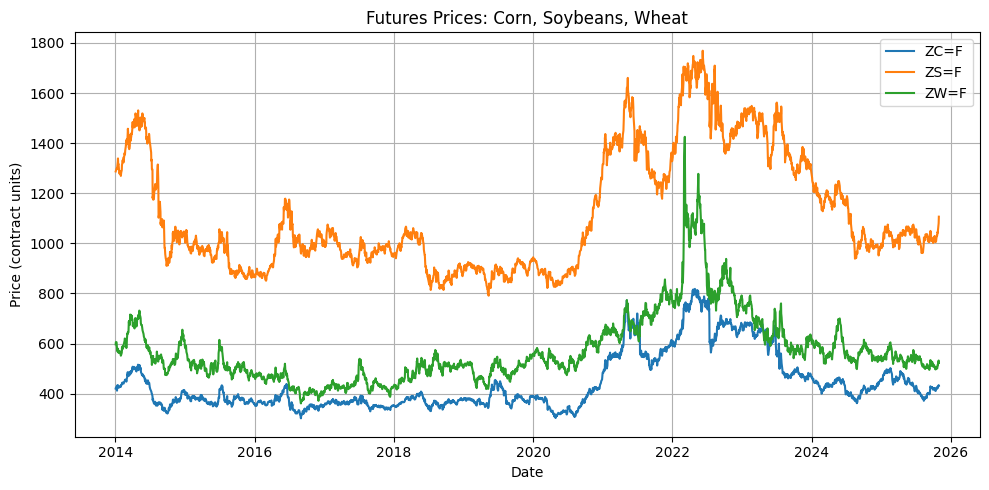

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
for t in TICKERS:
    plt.plot(prices_fut.index, prices_fut[t])
plt.title("Futures Prices: Corn, Soybeans, Wheat")
plt.xlabel("Date")
plt.ylabel("Price (contract units)")
plt.grid(True)
plt.legend(TICKERS)
plt.tight_layout()
plt.show()

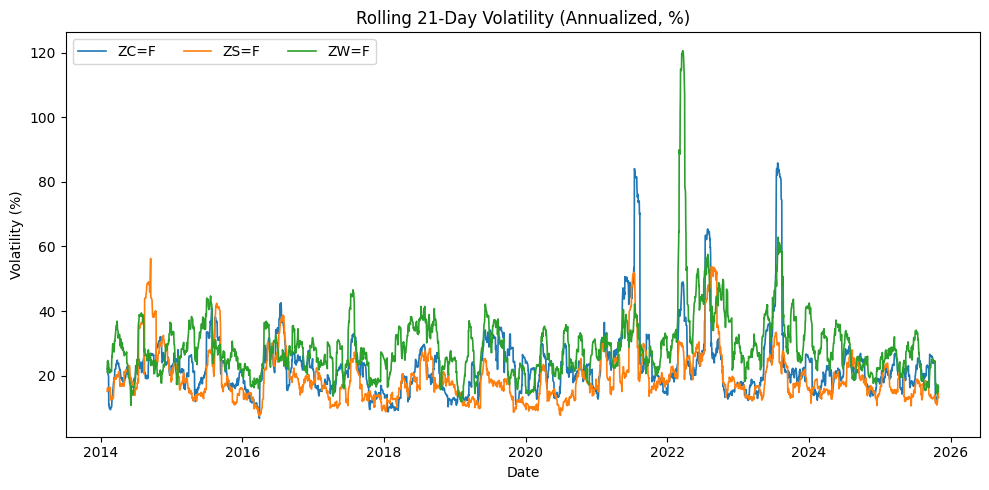

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
rv = returns.rolling(21).std() * (252**0.5) * 100
for c in rv.columns:
    ax.plot(rv.index, rv[c], label=c, linewidth=1.2)
ax.set_title("Rolling 21-Day Volatility (Annualized, %)")
ax.set_xlabel("Date")
ax.set_ylabel("Volatility (%)")
ax.legend(ncol=len(rv.columns))
plt.tight_layout()
plt.show()


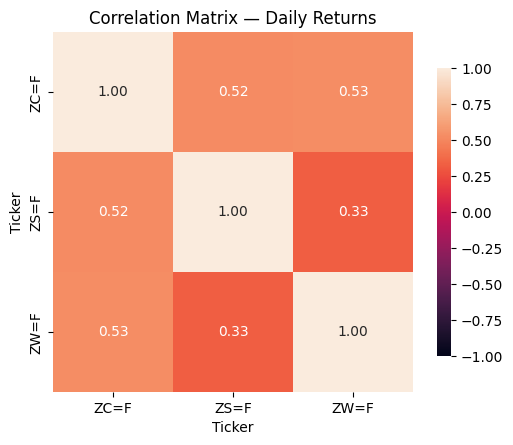

In [11]:
fig, ax = plt.subplots(figsize=(5.5, 4.5))
corr = returns.corr()
sns.heatmap(corr, annot=True, fmt=".2f", vmin=-1, vmax=1, square=True, ax=ax, cbar_kws={"shrink":0.8})
ax.set_title("Correlation Matrix — Daily Returns")
plt.tight_layout()
plt.show()

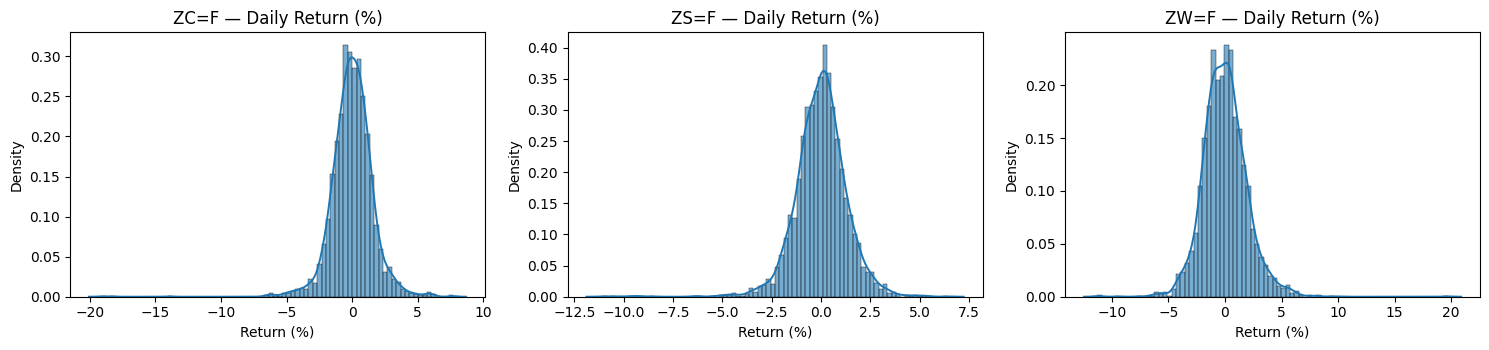

In [12]:
cols = returns.columns.tolist()
n = len(cols)
rows = 1 if n <= 3 else int(np.ceil(n/2))
cols_per_row = min(3, n)
fig, axes = plt.subplots(rows, cols_per_row, figsize=(5*cols_per_row, 3.6*rows))
axes = np.atleast_1d(axes).ravel()

for i, name in enumerate(cols):
    r = returns[name].dropna() * 100  # %
    sns.histplot(r, bins=80, stat="density", ax=axes[i], alpha=0.6)
    sns.kdeplot(r, ax=axes[i], linewidth=1.4)
    axes[i].set_title(f"{name} — Daily Return (%)")
    axes[i].set_xlabel("Return (%)"); axes[i].set_ylabel("Density")
for j in range(i+1, len(axes)):
    axes[j].axis("off")
plt.tight_layout()
plt.show()

## Simulation Engine

In [13]:
mu = returns.mean().values
cov = returns.cov().values

w, V = eigh((cov + cov.T) / 2.0)
w[w < 1e-10] = 1e-10
cov_psd = (V @ np.diag(w) @ V.T)
L = cholesky(cov_psd)

if DIST.lower() == "gaussian":
    Z = np.random.normal(size=(N_PATHS, HORIZON_DAYS, len(mu)))
else:
    g = np.random.gamma(T_DF/2.0, 2.0/T_DF, size=(N_PATHS, HORIZON_DAYS))
    Z = np.random.normal(size=(N_PATHS, HORIZON_DAYS, len(mu))) / np.sqrt(g)[:, :, None]

dR = (Z @ L.T) + mu
R_h = dR.sum(axis=1)

## Map prices to revenue P&L

1.   We map the prices and related to P&L
2.   We calculate VAR/ES
3.   We choose a target CFaR and a size to hedge
4.   Apply the hedge P&L and compose VAR/ES


In [14]:
last_cash = prices_cash.iloc[-1]
tickers = list(last_cash.index)
qty_vec = np.array([EXPOSURE_BUSHELS.get(t, 0.0) for t in tickers])

price_end = {}
for i, t in enumerate(tickers):
    price_end[t] = last_cash[t] * np.exp(R_h[:, i])
price_end = pd.DataFrame(price_end)  # paths x assets

start_val = last_cash.values * qty_vec
end_val = price_end.values * qty_vec
pnl_unhedged = (end_val - start_val).sum(axis=1)

alpha_var = 1 - CONF_VAR
q_var = np.quantile(pnl_unhedged, alpha_var)
VaR_u = -q_var
alpha_es = 1 - CONF_ES
q_es = np.quantile(pnl_unhedged, alpha_es)
ES_u = -pnl_unhedged[pnl_unhedged <= q_es].mean()

print("UNHEDGED RISK (USD)")
print({"VaR_%": int(CONF_VAR*100), "VaR_USD": round(VaR_u, 2),
       "ES_%": int(CONF_ES*100), "ES_USD": round(ES_u, 2)})

target_cfar_usd = CFAR_TARGET_FRACTION * VaR_u

sigma_h = R_h.std(axis=0)
risk_notional = last_cash.values * qty_vec
contrib = np.abs(risk_notional * sigma_h)
w_contrib = contrib / (contrib.sum() + 1e-12)

reduction_needed = max(VaR_u - target_cfar_usd, 0.0)
per_asset_reduction = w_contrib * reduction_needed
contract_usd = FUT_CONTRACT_SIZE * prices_fut.iloc[-1].values
hedge_contracts = np.round(per_asset_reduction / (contract_usd + 1e-12)).astype(int)

hedge_series = pd.Series(hedge_contracts, index=tickers)
print("HEDGE CONTRACTS (short futures, + = more short)")
print(hedge_series)

fut_last = prices_fut.iloc[-1]
fut_end = {}
for i, t in enumerate(tickers):
    fut_end[t] = fut_last[t] * np.exp(R_h[:, i])
fut_end = pd.DataFrame(fut_end)

dP = fut_end.values - fut_last.values
mtm = -(dP * (FUT_CONTRACT_SIZE * hedge_contracts))   # short futures MTM
pnl_hedged = pnl_unhedged + mtm.sum(axis=1)

q_var_h = np.quantile(pnl_hedged, alpha_var)
VaR_h = -q_var_h
q_es_h = np.quantile(pnl_hedged, alpha_es)
ES_h = -pnl_hedged[pnl_hedged <= q_es_h].mean()

print("HEDGED RISK (USD)")
print({"VaR_%": int(CONF_VAR*100), "VaR_USD": round(VaR_h, 2),
       "ES_%": int(CONF_ES*100), "ES_USD": round(ES_h, 2),
       "VaR_Reduction_%": round(100*(1 - VaR_h/max(VaR_u,1e-9)), 2)})

UNHEDGED RISK (USD)
{'VaR_%': 99, 'VaR_USD': np.float64(228361980.78), 'ES_%': 97, 'ES_USD': np.float64(229831348.91)}
HEDGE CONTRACTS (short futures, + = more short)
ZC=F    24
ZS=F    12
ZW=F    24
dtype: int64
HEDGED RISK (USD)
{'VaR_%': 99, 'VaR_USD': np.float64(200547175.32), 'ES_%': 97, 'ES_USD': np.float64(201731375.95), 'VaR_Reduction_%': np.float64(12.18)}


## Visualize the diagnostic and do the reporting

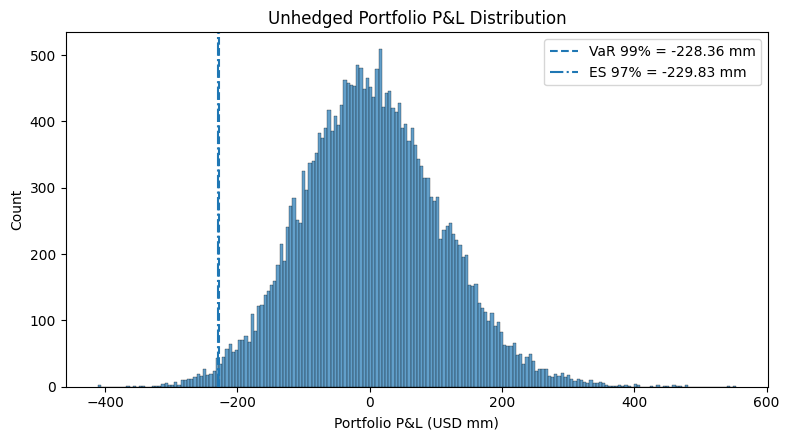

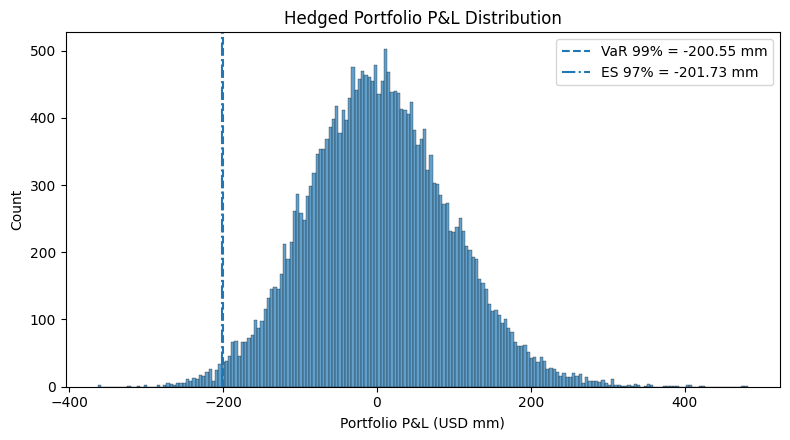

In [15]:
def plot_pnl_dist(pnl, title, conf_var=CONF_VAR, conf_es=CONF_ES):
    fig, ax = plt.subplots(figsize=(8, 4.5))
    sns.histplot(pnl/1e6, bins=200, ax=ax, alpha=0.7)  # in $mm
    q_var = np.quantile(pnl, 1-conf_var)/1e6
    q_es  = np.quantile(pnl, 1-conf_es)/1e6
    es_mean = pnl[pnl <= np.quantile(pnl, 1-conf_es)].mean()/1e6
    ax.axvline(q_var, linestyle="--", linewidth=1.5, label=f"VaR {int(conf_var*100)}% = {q_var:.2f} mm")
    ax.axvline(es_mean, linestyle="-.", linewidth=1.5, label=f"ES {int(conf_es*100)}% = {es_mean:.2f} mm")
    ax.set_title(title)
    ax.set_xlabel("Portfolio P&L (USD mm)")
    ax.legend()
    plt.tight_layout()
    plt.show()

plot_pnl_dist(pnl_unhedged, "Unhedged Portfolio P&L Distribution")
plot_pnl_dist(pnl_hedged,   "Hedged Portfolio P&L Distribution")

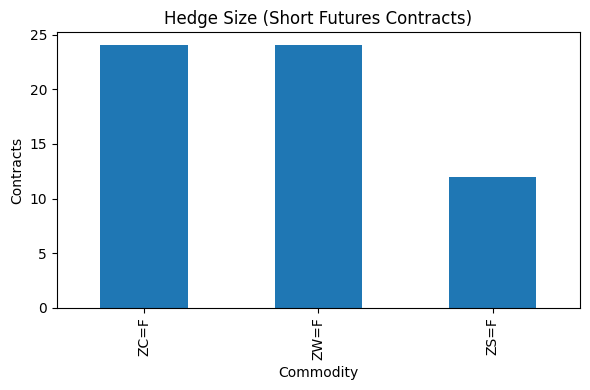

In [16]:
fig, ax = plt.subplots(figsize=(6, 4))
hedge_series.sort_values(ascending=False).plot(kind="bar", ax=ax)
ax.set_title("Hedge Size (Short Futures Contracts)")
ax.set_ylabel("Contracts")
ax.set_xlabel("Commodity")
plt.tight_layout()
plt.show()

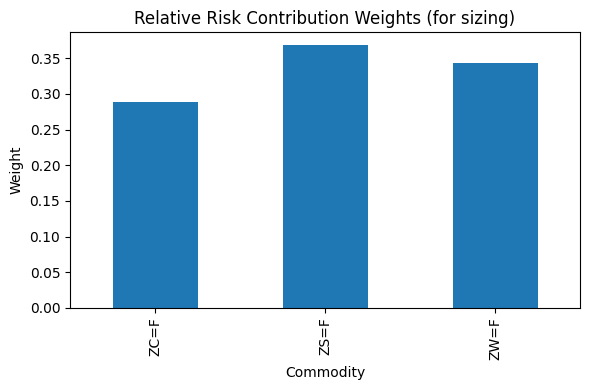

In [17]:
fig, ax = plt.subplots(figsize=(6, 4))
(pd.Series(contrib, index=prices_fut.columns) / (contrib.sum()+1e-12)).plot(kind="bar", ax=ax)
ax.set_title("Relative Risk Contribution Weights (for sizing)")
ax.set_ylabel("Weight")
ax.set_xlabel("Commodity")
plt.tight_layout()
plt.show()

## Deterministic Stress Test

SIMPLE STRESSES (USD P&L)
Price_-20%: -302790000.0
Price_-40%: -605580000.0


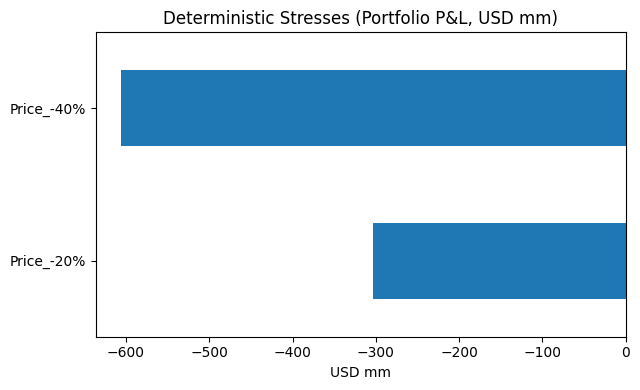

In [18]:
def stress_pnl(price_drop_pct):
    end_prices = last_cash * (1 - price_drop_pct)
    pnl = (end_prices.values * qty_vec - last_cash.values * qty_vec).sum()
    return pnl

stresses = {
    "Price_-20%": stress_pnl(0.20),
    "Price_-40%": stress_pnl(0.40),
}
print("SIMPLE STRESSES (USD P&L)")
for k, v in stresses.items():
    print(f"{k}: {round(v,2)}")


stress_df = pd.Series(stresses).sort_index()
fig, ax = plt.subplots(figsize=(6.5, 4))
(stress_df/1e6).plot(kind="barh", ax=ax)
ax.set_title("Deterministic Stresses (Portfolio P&L, USD mm)")
ax.set_xlabel("USD mm")
plt.tight_layout()
plt.show()


In [19]:

import numpy as np
import pandas as pd

BAND_WINDOW_DAYS = 120
BAND_MODE = "percent"
BAND_PCT_WIDTH = 0.12
ROBUST_K = 2.0

VOL_WINDOW = 21
VOL_EWMA_ALPHA = 0.06

PATIENCE_LOOKBACK = 10
PATIENCE_CORR_MIN = 0.2

MOMENTUM_FAST = 5
MOMENTUM_TREND = 20

BASE_FLOOR = 0.10
MAX_COVERAGE = 0.80
MAX_DAILY_ADJ = 0.20

IV_CHEAP_PCTL = 0.30
PUT_DELTA_HINT = 0.225

HARVEST_WEEKS = {
    "ZC=F": [],  # e.g., [14, 15, 16, 17, 18]
    "ZS=F": [],
    "ZW=F": [],
}

CURRENT_COVERAGE = {
    "ZC=F": 0.00,
    "ZS=F": 0.00,
    "ZW=F": 0.00,
}


basis_df = None
BASIS_VOL_WINDOW = 21
BASIS_VOL_PCTL = 0.70  # above this percentile → "messy basis" boost



def _pick_active_prices_returns():
    g = globals()
    if "prices_cash_ars" in g and isinstance(g["prices_cash_ars"], pd.DataFrame):
        prices = g["prices_cash_ars"]
        rets = g.get("returns_in_ars", None)
    elif "prices_cash_brl" in g and isinstance(g["prices_cash_brl"], pd.DataFrame):
        prices = g["prices_cash_brl"]
        rets = g.get("returns_in_brl", None)
    else:
        prices = g["prices_cash"] if "prices_cash" in g else g["prices_fut"]
        rets = g.get("returns", None)

    if rets is None or not isinstance(rets, pd.DataFrame):
        rets = np.log(prices / prices.shift(1)).dropna()
    return prices, rets


def _rolling_median_mad(s, window=BAND_WINDOW_DAYS):
    med = s.rolling(window, min_periods=max(5, window//3)).median()
    mad = (s - med).abs().rolling(window, min_periods=max(5, window//3)).median()
    rmad = 1.4826 * mad
    return med, rmad


def _robust_band(price_col, window=BAND_WINDOW_DAYS, mode=BAND_MODE, pct_width=BAND_PCT_WIDTH, k=ROBUST_K):
    if mode == "percent":
        mid = price_col.rolling(window, min_periods=max(5, window//3)).median()
        width = pct_width * mid
    else:
        mid, rmad = _rolling_median_mad(price_col, window)
        width = k * rmad
    lower = mid - width
    upper = mid + width
    return mid, lower, upper


def _vol_proxy(returns_col, window=VOL_WINDOW, alpha=VOL_EWMA_ALPHA):
    abs_r = returns_col.abs()
    ew = abs_r.ewm(alpha=alpha, adjust=False).mean()
    return ew * np.sqrt(252)  # annualized-style proxy


def _patience_signal(price_col, vol_col, lookback=PATIENCE_LOOKBACK, min_corr=PATIENCE_CORR_MIN):
    dp = price_col.diff()
    dv = vol_col.diff()
    rolling_corr = dp.rolling(lookback).corr(dv)
    last_up = (dp.iloc[-1] or 0.0) > 0 and (dv.iloc[-1] or 0.0) > 0
    corr_ok = (rolling_corr.iloc[-1] or 0.0) >= min_corr
    if last_up and corr_ok:
        return "red"     # be patient (delay larger sales; prefer protective puts if vol is cheap)
    if ((dp.iloc[-1] or 0.0) > 0 and (dv.iloc[-1] or 0.0) <= 0) or \
       ((dp.iloc[-1] or 0.0) <= 0 and (dv.iloc[-1] or 0.0) > 0) or \
       ((rolling_corr.iloc[-1] or 0.0) > 0):
        return "amber"   # mixed
    return "green"


def _momentum_fade(price_col, upper_band, fast=MOMENTUM_FAST, trend=MOMENTUM_TREND):
    above_upper = price_col.iloc[-1] > upper_band.iloc[-1]
    fast_chg = price_col.iloc[-1] - price_col.shift(fast).iloc[-1]
    trend_chg = price_col.iloc[-1] - price_col.shift(trend).iloc[-1]
    fading = (fast_chg < 0) and (trend_chg >= 0)
    return bool(above_upper and fading)


def _season_floor(idx, weeks):
    if not weeks:
        return 0.0
    wk = idx.isocalendar().week.iloc[-1]
    return 0.20 if int(wk) in set(weeks) else 0.0  # add 20% floor in congestion weeks


def _basis_risk_boost(ticker, basis_frame, idx_last, window=BASIS_VOL_WINDOW, pct=BASIS_VOL_PCTL):
    if basis_frame is None or ticker not in basis_frame.columns:
        return 0.0
    b = basis_frame[ticker].reindex(basis_frame.index.union(pd.DatetimeIndex([idx_last]))).ffill().loc[basis_frame.index]
    bs = b.rolling(window, min_periods=max(5, window//3)).std()
    last = float(bs.iloc[-1])
    thresh = float(bs.quantile(pct))
    return 0.15 if last >= thresh and not np.isnan(last) else 0.0


def _iv_is_cheap(vol_series, pctl=IV_CHEAP_PCTL):
    last = float(vol_series.iloc[-1])
    if not np.isfinite(last):
        return False
    thresh = float(vol_series.quantile(pctl))
    return last <= thresh


def _clip01(x):
    return float(max(0.0, min(1.0, x)))


def _one_liner_reason(price, mid, lower, upper, patience, mom_fade, basis_boost, season_floor):
    pos = "below band" if price < lower else ("inside band" if price <= upper else "above band")
    bits = []
    bits.append(f"price {pos}")
    if mom_fade:
        bits.append("momentum fading near high")
    if patience == "red":
        bits.append("price↑ + vol↑ (be patient)")
    elif patience == "amber":
        bits.append("mixed price/vol")
    if basis_boost > 0:
        bits.append("basis messy")
    if season_floor > 0:
        bits.append("seasonal floor active")
    return "; ".join(bits)


def compute_policy_panel():
    """Compute daily hedge policy panel by ticker with signal → action mapping."""
    prices, rets = _pick_active_prices_returns()
    last_idx = prices.index[-1]
    last_prices = prices.iloc[-1]
    rows = []

    for t in last_prices.index:
        p = prices[t]
        mid, lo, hi = _robust_band(p)

        # Vol proxy & Patience
        volp = _vol_proxy(rets[t].reindex(p.index).fillna(0.0))
        patience = _patience_signal(p, volp)

        # Momentum fade near the upper band
        momfade = _momentum_fade(p, hi)

        # Basis risk & seasonality floors
        bboost = _basis_risk_boost(t, basis_df, last_idx) if basis_df is not None else 0.0
        sfloor = _season_floor(p.index, HARVEST_WEEKS.get(t, []))

        # Base target coverage (plain policy)
        target = BASE_FLOOR + sfloor + bboost
        if p.iloc[-1] > hi.iloc[-1]:
            target += 0.25  # expensive → sell some
            if momfade:
                target += 0.15  # fading → sell a bit more
        elif p.iloc[-1] < lo.iloc[-1]:
            target -= 0.15  # cheap → ease off

        # Patience reduces immediate selling
        if patience == "red":
            target -= 0.15
        elif patience == "amber":
            target -= 0.05

        target = _clip01(min(target, MAX_COVERAGE))

        # Smooth daily change
        curr = float(CURRENT_COVERAGE.get(t, 0.0))
        unpriced = max(0.0, 1.0 - curr)
        delta = target - curr
        max_move = MAX_DAILY_ADJ * (unpriced if delta > 0 else curr)
        delta_capped = float(np.sign(delta) * min(abs(delta), max_move))

        # Contracts (futures) or options hint
        fut_price_now = prices_fut[t].iloc[-1] if t in prices_fut.columns else p.iloc[-1]
        bu_to_trade = delta_capped * EXPOSURE_BUSHELS.get(t, 0.0)
        fut_contracts = int(round(bu_to_trade / max(FUT_CONTRACT_SIZE, 1e-9)))

        ivcheap = _iv_is_cheap(volp)
        action = "WAIT"
        action_detail = "Hold; no change."
        if delta_capped > 1e-9:
            if patience == "red" and ivcheap:
                action = "BUY_PUTS"
                action_detail = f"Buy ~{PUT_DELTA_HINT:.3f}Δ protective puts on ~{bu_to_trade:,.0f} bu (hint; not priced here)."
                fut_contracts = 0
            else:
                action = "SELL_FUTURES"
                action_detail = f"Short {fut_contracts} futures to raise coverage."
        elif delta_capped < -1e-9:
            action = "REDUCE_HEDGE"
            fut_contracts = -fut_contracts
            action_detail = f"Lift {abs(fut_contracts)} short futures (reduce coverage)."

        reason = _one_liner_reason(
            price=float(p.iloc[-1]),
            mid=float(mid.iloc[-1]) if pd.notna(mid.iloc[-1]) else float(p.iloc[-1]),
            lower=float(lo.iloc[-1]) if pd.notna(lo.iloc[-1]) else float(p.iloc[-1]),
            upper=float(hi.iloc[-1]) if pd.notna(hi.iloc[-1]) else float(p.iloc[-1]),
            patience=patience,
            mom_fade=momfade,
            basis_boost=bboost,
            season_floor=sfloor,
        )

        dist_to_mid = abs(float(p.iloc[-1]) - float(mid.iloc[-1])) / max(1e-9, float(mid.iloc[-1])) if pd.notna(mid.iloc[-1]) else np.nan

        rows.append({
            "date": last_idx,
            "ticker": t,
            "price": float(p.iloc[-1]),
            "band_low": float(lo.iloc[-1]) if pd.notna(lo.iloc[-1]) else np.nan,
            "band_mid": float(mid.iloc[-1]) if pd.notna(mid.iloc[-1]) else np.nan,
            "band_high": float(hi.iloc[-1]) if pd.notna(hi.iloc[-1]) else np.nan,
            "dist_to_mid_%": 100.0 * dist_to_mid if np.isfinite(dist_to_mid) else np.nan,
            "patience": patience,                  # green / amber / red
            "momentum_fade": bool(momfade),
            "basis_boost": float(bboost),
            "season_floor": float(sfloor),
            "current_coverage": curr,
            "target_coverage": target,
            "delta_coverage_today": delta_capped,
            "rec_action": action,
            "rec_futures_contracts": int(fut_contracts),
            "rec_bushels": float(bu_to_trade),
            "action_detail": action_detail,
            "reason": reason,
        })

    panel = pd.DataFrame(rows).set_index(["date", "ticker"])
    return panel


# -------- Run once per day to produce the policy panel --------
policy_panel = compute_policy_panel()
print("\nHEDGE POLICY DAILY PANEL")
print(policy_panel[[
    "price","band_low","band_mid","band_high",
    "dist_to_mid_%","patience","momentum_fade",
    "current_coverage","target_coverage","delta_coverage_today",
    "rec_action","rec_futures_contracts","rec_bushels","action_detail","reason"
]].round(4))



HEDGE POLICY DAILY PANEL
                     price  band_low  band_mid  band_high  dist_to_mid_%  \
date       ticker                                                          
2025-10-30 ZC=F     432.25    368.39   418.625     468.86         3.2547   
           ZS=F    1106.50    902.00  1025.000    1148.00         7.9512   
           ZW=F     522.25    460.13   522.875     585.62         0.1195   

                  patience  momentum_fade  current_coverage  target_coverage  \
date       ticker                                                              
2025-10-30 ZC=F      amber          False               0.0             0.05   
           ZS=F        red          False               0.0             0.00   
           ZW=F      amber          False               0.0             0.05   

                   delta_coverage_today    rec_action  rec_futures_contracts  \
date       ticker                                                              
2025-10-30 ZC=F                 

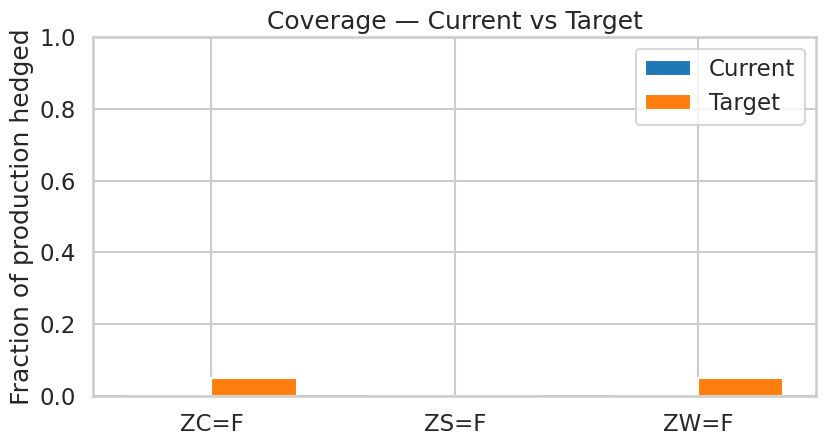

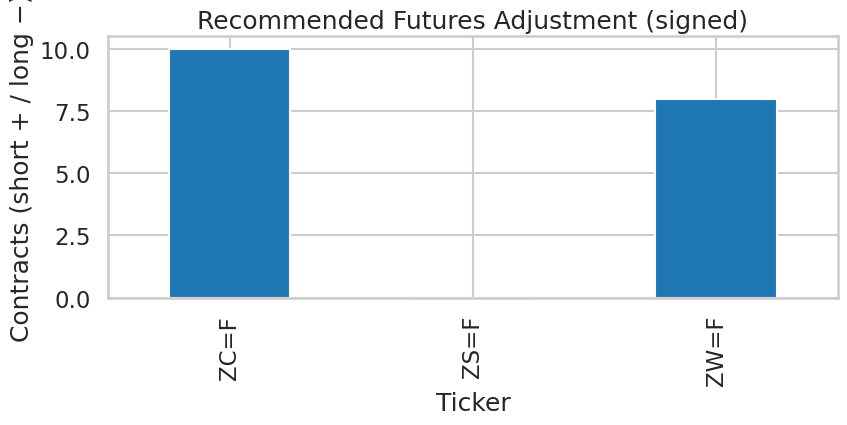

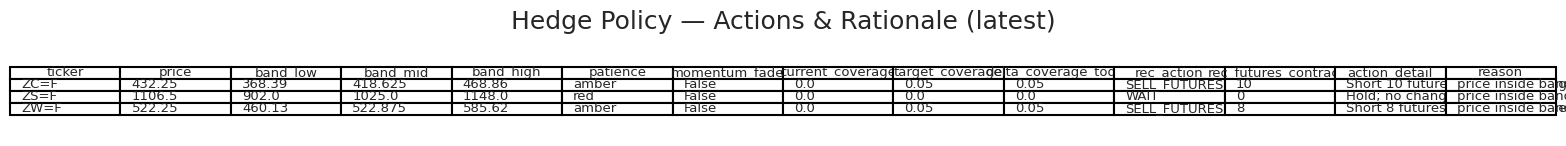

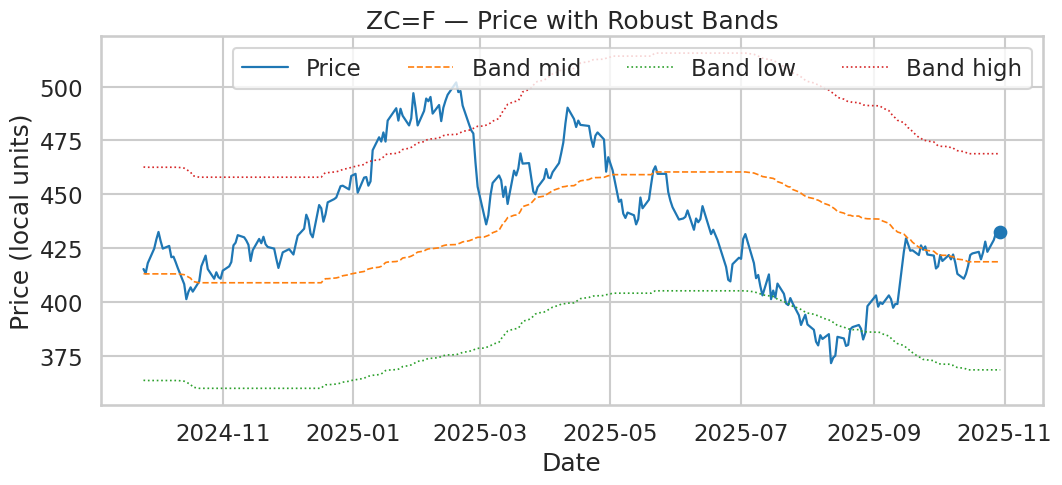

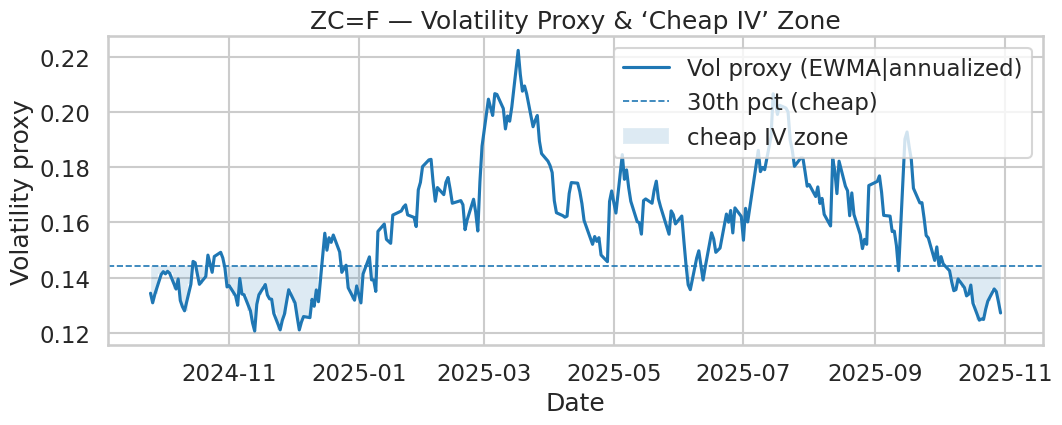

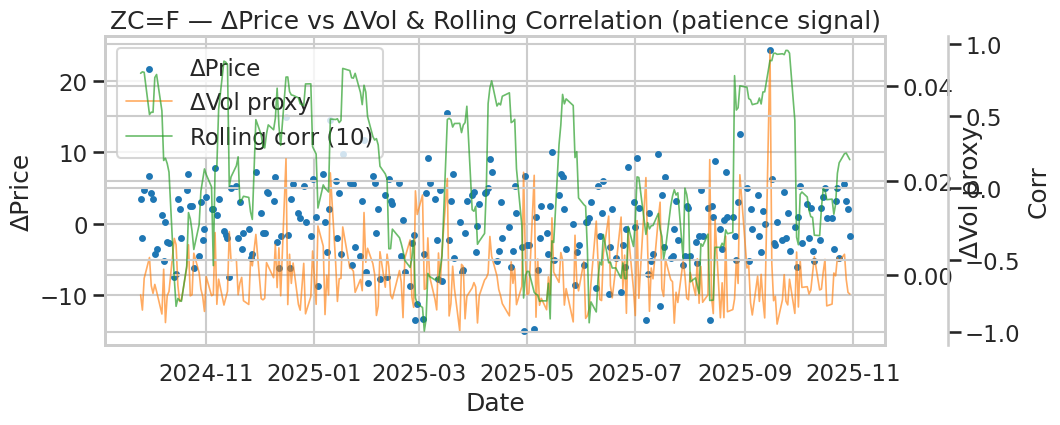

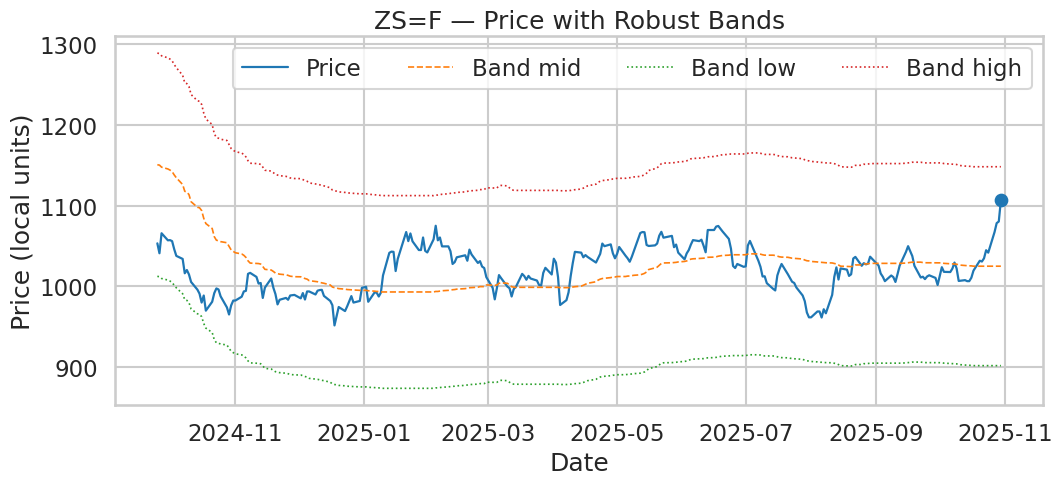

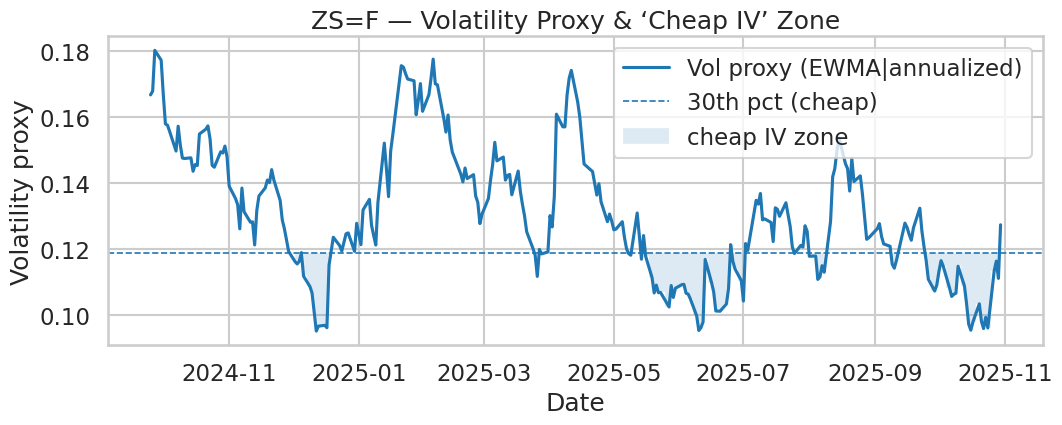

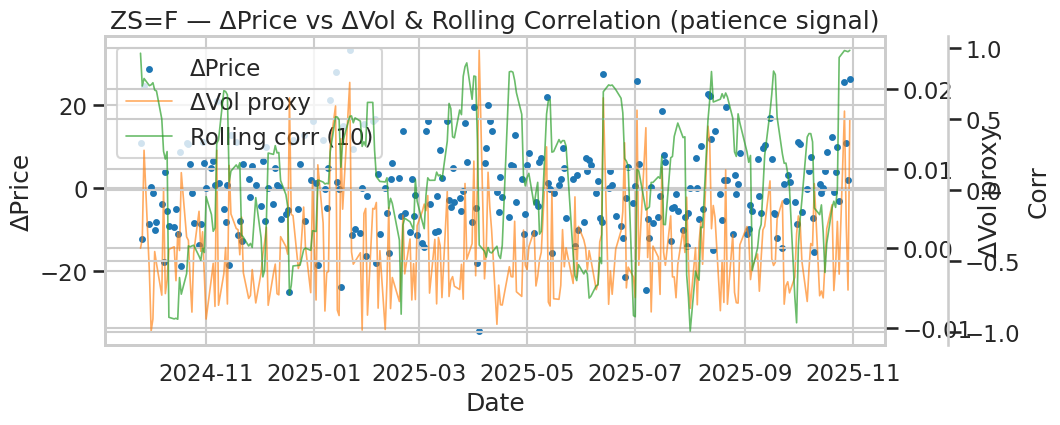

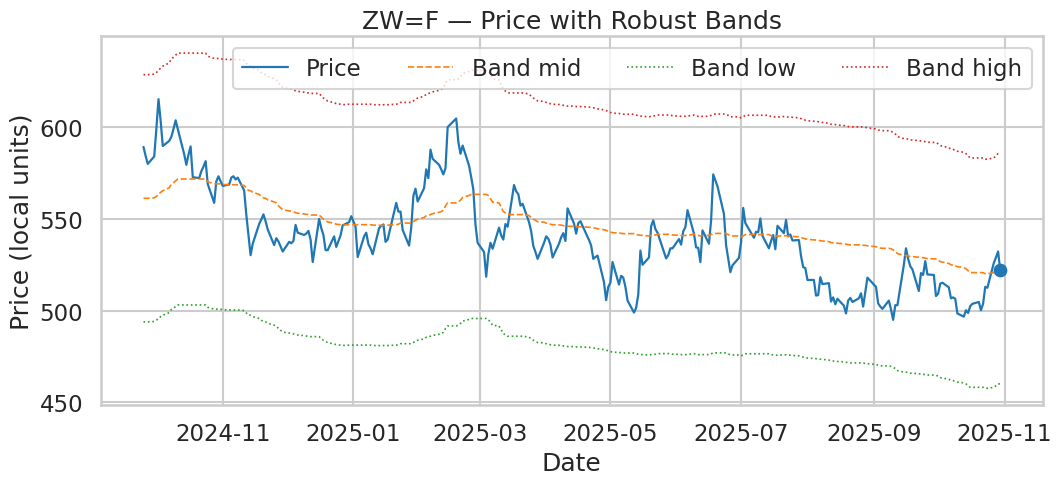

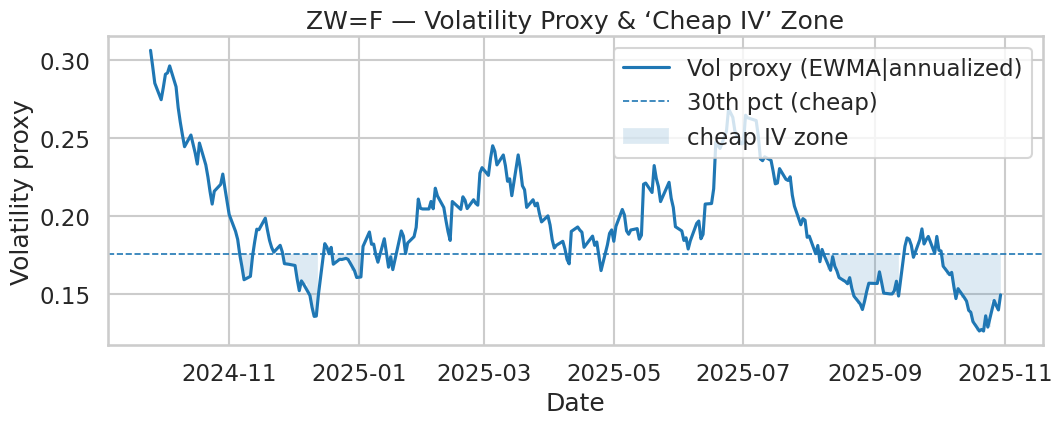

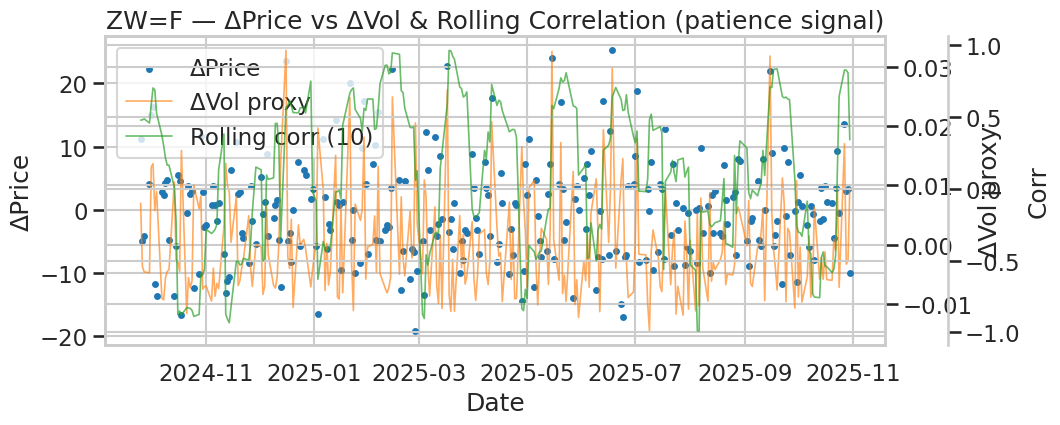

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")
sns.set_style("whitegrid")

PLOT_LOOKBACK_DAYS = 400

def _last_window(df, days=PLOT_LOOKBACK_DAYS):
    if df is None or len(df.index) == 0:
        return df
    cutoff = df.index.max() - pd.Timedelta(days=days)
    return df.loc[df.index >= cutoff]

def _bands_for_full_series(series):
    mid, lo, hi = _robust_band(series)
    return mid, lo, hi

def _seasonal_spans(ax, idx, weeks):
    if not weeks:
        return
    iso = idx.isocalendar().week
    wkset = set(int(w) for w in weeks)
    in_span = False
    span_start = None
    for i, (d, w) in enumerate(zip(idx, iso)):
        if int(w) in wkset and not in_span:
            in_span = True
            span_start = d
        elif int(w) not in wkset and in_span:
            ax.axvspan(span_start, idx[i-1], alpha=0.08)
            in_span = False
    if in_span:
        ax.axvspan(span_start, idx[-1], alpha=0.08)

def plot_price_and_bands(prices, ticker):
    p = prices[ticker].dropna()
    p = _last_window(p)
    mid, lo, hi = _bands_for_full_series(prices[ticker].dropna())
    mid, lo, hi = mid.reindex(p.index), lo.reindex(p.index), hi.reindex(p.index)

    fig, ax = plt.subplots(figsize=(11, 5.2))
    ax.plot(p.index, p.values, label="Price", linewidth=1.6)
    ax.plot(mid.index, mid.values, label="Band mid", linestyle="--", linewidth=1.2)
    ax.plot(lo.index,  lo.values,  label="Band low", linestyle=":", linewidth=1.2)
    ax.plot(hi.index,  hi.values,  label="Band high", linestyle=":", linewidth=1.2)

    _seasonal_spans(ax, p.index, HARVEST_WEEKS.get(ticker, []))

    last = p.iloc[-1]
    ax.scatter([p.index[-1]], [last], s=70, zorder=5)
    ax.set_title(f"{ticker} — Price with Robust Bands")
    ax.set_xlabel("Date"); ax.set_ylabel("Price (local units)")
    ax.legend(ncol=4, frameon=True)
    plt.tight_layout()
    plt.show()

def plot_vol_proxy(prices, returns, ticker):
    r = returns[ticker].reindex(prices.index).dropna()
    r = _last_window(r)
    volp = _vol_proxy(r).dropna()
    volp = _last_window(volp)
    if len(volp) == 0:
        return

    cheap_thr = volp.quantile(IV_CHEAP_PCTL)

    fig, ax = plt.subplots(figsize=(11, 4.6))
    ax.plot(volp.index, volp.values, label="Vol proxy (EWMA|annualized)")
    ax.axhline(cheap_thr, linestyle="--", linewidth=1.2, label=f"{int(IV_CHEAP_PCTL*100)}th pct (cheap)")

    cheap_mask = volp <= cheap_thr
    if cheap_mask.any():
        ax.fill_between(volp.index, volp.values, cheap_thr,
                        where=cheap_mask, alpha=0.15, step="mid", label="cheap IV zone")

    ax.set_title(f"{ticker} — Volatility Proxy & ‘Cheap IV’ Zone")
    ax.set_xlabel("Date"); ax.set_ylabel("Volatility proxy")
    ax.legend(frameon=True)
    plt.tight_layout()
    plt.show()

def plot_price_vs_vol_change(prices, returns, ticker, lookback=PATIENCE_LOOKBACK):
    # For “patience” intuition: Δprice vs Δvol, plus rolling corr
    r = returns[ticker].reindex(prices.index).fillna(0.0)
    volp = _vol_proxy(r).fillna(0.0)
    dp = prices[ticker].diff().reindex(volp.index).fillna(0.0)
    dv = volp.diff().fillna(0.0)
    corr = dp.rolling(lookback).corr(dv)

    # focus on last window
    window_idx = _last_window(pd.DataFrame({"dp": dp, "dv": dv, "corr": corr}))
    dpw, dvw, corrw = window_idx["dp"], window_idx["dv"], window_idx["corr"]

    fig, ax = plt.subplots(figsize=(11, 4.6))
    sc = ax.scatter(dpw.index, dpw.values, s=12, label="ΔPrice")
    ax2 = ax.twinx()
    ax2.plot(dvw.index, dvw.values, color="tab:orange", alpha=0.65, linewidth=1.2, label="ΔVol proxy")
    ax3 = ax.twinx()
    ax3.spines.right.set_position(("axes", 1.08))
    ax3.plot(corrw.index, corrw.values, color="tab:green", alpha=0.7, linewidth=1.2, label=f"Rolling corr ({lookback})")

    # Legend merge
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    h3, l3 = ax3.get_legend_handles_labels()
    ax.legend(h1+h2+h3, l1+l2+l3, loc="upper left", frameon=True)

    ax.set_title(f"{ticker} — ΔPrice vs ΔVol & Rolling Correlation (patience signal)")
    ax.set_xlabel("Date")
    ax.set_ylabel("ΔPrice")
    ax2.set_ylabel("ΔVol proxy")
    ax3.set_ylabel("Corr")
    plt.tight_layout()
    plt.show()

def plot_basis_risk(basis_frame, ticker):
    if basis_frame is None or ticker not in basis_frame.columns:
        return
    b = basis_frame[ticker].dropna()
    b = _last_window(b)
    if len(b) == 0:
        return
    bs = b.rolling(BASIS_VOL_WINDOW, min_periods=max(5, BASIS_VOL_WINDOW//3)).std()
    thr = bs.quantile(BASIS_VOL_PCTL)

    fig, ax = plt.subplots(figsize=(11, 4.4))
    ax.plot(bs.index, bs.values, label="Rolling basis std")
    ax.axhline(thr, linestyle="--", linewidth=1.2, label=f"{int(BASIS_VOL_PCTL*100)}th pct threshold")
    ax.fill_between(bs.index, bs.values, thr, where=(bs >= thr), alpha=0.12, label="‘Messy basis’ region")
    ax.set_title(f"{ticker} — Basis Volatility Monitor")
    ax.set_xlabel("Date"); ax.set_ylabel("Std (basis units)")
    ax.legend(frameon=True)
    plt.tight_layout()
    plt.show()

def plot_coverage_and_actions(panel):
    latest = panel.reset_index().sort_values("ticker").groupby("ticker").tail(1).set_index("ticker")

    fig, ax = plt.subplots(figsize=(8.6, 4.8))
    x = np.arange(len(latest.index))
    width = 0.35
    ax.bar(x - width/2, latest["current_coverage"], width, label="Current")
    ax.bar(x + width/2, latest["target_coverage"], width, label="Target")
    ax.set_xticks(x); ax.set_xticklabels(latest.index)
    ax.set_ylim(0, 1.0)
    ax.set_title("Coverage — Current vs Target")
    ax.set_ylabel("Fraction of production hedged")
    ax.legend(frameon=True)
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=(8.6, 4.6))
    latest["rec_futures_contracts"].plot(kind="bar", ax=ax)
    ax.set_title("Recommended Futures Adjustment (signed)")
    ax.set_ylabel("Contracts (short + / long −)")
    ax.set_xlabel("Ticker")
    plt.tight_layout()
    plt.show()

def plot_reason_table(panel):
    latest = panel.reset_index().sort_values(["date","ticker"]).groupby("ticker").tail(1)
    cols = ["ticker","price","band_low","band_mid","band_high","patience",
            "momentum_fade","current_coverage","target_coverage","delta_coverage_today",
            "rec_action","rec_futures_contracts","action_detail","reason"]
    latest = latest[cols]
    fig, ax = plt.subplots(figsize=(16, 0.6 + 0.4*len(latest)))
    ax.axis("off")
    tbl = ax.table(cellText=latest.values,
                   colLabels=latest.columns,
                   loc="center",
                   cellLoc="left")
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(9.5)
    tbl.scale(1, 1.1)
    ax.set_title("Hedge Policy — Actions & Rationale (latest)", pad=12)
    plt.tight_layout()
    plt.show()

def draw_all_policy_plots(policy_panel):
    # Resolve active series used for bands/vol
    prices, rets = _pick_active_prices_returns()
    tickers = list(prices.columns)

    plot_coverage_and_actions(policy_panel)
    plot_reason_table(policy_panel)

    for t in tickers:
        try:
            plot_price_and_bands(prices, t)
            plot_vol_proxy(prices, rets, t)
            plot_price_vs_vol_change(prices, rets, t, lookback=PATIENCE_LOOKBACK)
            plot_basis_risk(basis_df, t)
        except Exception as e:
            print(f"[warn] Skipped {t} plot due to: {e}")

draw_all_policy_plots(policy_panel)